In [82]:
import pandas as pd
import numpy as np
import sys
print (sys.version) 

%matplotlib inline
import matplotlib.pyplot as plt   
import statsmodels.api as sm  
import seaborn as sns
sns.set_style('darkgrid')

import random

import warnings
warnings.filterwarnings("ignore")
sns.set_context('notebook')

3.5.3 |Anaconda 4.4.0 (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]


In [83]:
%%time
joined_df = pd.read_csv('S:\\Traffic\TFO I&II OT & Claims.csv',  parse_dates=['DOI', 'WORK_DATE', 'Time of Inj', 'Birth Date', 'Hire Date'])
# joined_df = pd.read_csv('/Users/mikeludwig/Dropbox/city_data/TFO I&II OT & Claims.csv',  parse_dates=['DOI', 'WORK_DATE', 'Time of Inj', 'Birth Date', 'Hire Date'])

Wall time: 4min 5s


In [84]:
# Remove extra "Unnamed:0" column and reset the index

joined_df= joined_df.drop(joined_df.columns[:1], axis=1)
joined_df = joined_df.reset_index(drop=True)

In [85]:
# Create columns for 'Quarter' and make sure 'Day of Week' is applied to all relevant entries

joined_df['Quarter'] = pd.PeriodIndex(joined_df['WORK_DATE'], freq='Q-JUN').strftime('Q%q')

joined_df['Day of Week'] = joined_df['WORK_DATE'].dt.weekday_name

# Show dataframe columns, along with each one's associated data type
joined_df.dtypes

EMPLOYEE_ID                       int64
EMPLOYEE_NAME                    object
PAYROLL_YEAR                     object
JOB_CLASS                        object
JOB_CLASS_TITLE                  object
DEPT                              int64
DIV                             float64
PP                                int64
WORK_DATE                datetime64[ns]
VAR_CODE                         object
VARIATION_DESCRIPTION            object
TOTALING_GROUP                   object
HOURS                             int64
VAR_RATE                        float64
PAY_AMOUNT                        int64
Claim Number                    float64
DOI                      datetime64[ns]
Time of Inj              datetime64[ns]
Day of Week                      object
Open Date                        object
Closed Date                      object
Status                           object
Litigated                        object
Cd                              float64
Nature of Injury                 object


In [86]:
# How many distinct employees are in the dataset?

len(joined_df['EMPLOYEE_NAME'].unique())

762

In [87]:
# Create lists of injured and non-injured employees
# Create dataframes of injured and non-injured employees, taken from the lists

injured_list = joined_df[joined_df['DOI'].notnull()]['EMPLOYEE_NAME'].unique().tolist()
not_injured_list = joined_df[joined_df['DOI'].isnull()]['EMPLOYEE_NAME'].unique().tolist()

injured_df = joined_df[joined_df['EMPLOYEE_NAME'].isin(injured_list)].reset_index(drop=True)
not_injured_df = joined_df[joined_df['EMPLOYEE_NAME'].isin(not_injured_list)].reset_index(drop=True)

In [88]:
# List of potentially relevant variation codes from co-worker, for RT (regular time)

RT_var_codes = ['HW', 'AR', 'TU', 'TD']

In [89]:
#The most common types of injury, shown by percent of total

nature_injury_grouped = joined_df.groupby(['Nature of Injury'])['EMPLOYEE_NAME'].agg({'Count Distinct': 'nunique'})

pct_total = lambda x: (x *100) / x.sum()
transformed = nature_injury_grouped.transform(pct_total)

transformed.sort_values(by = 'Count Distinct', ascending = False).head(15)

,Count Distinct
Nature of Injury,
Strain,44.794953
Contusion,14.195584
Sprain,11.987382
Mental Stress,4.100946
No Physical Injury,4.100946
All Other Cumulative,3.154574
Inflammation,2.523659
Multiple Physical Injuries,2.208202
"All Other Specific Injuries,",1.892744


In [90]:
# The unique causes of injury, cited by claim

injured_df['Claim Cause Group'].unique()

array(['Strain or Injury By', 'Miscellaneous Causes', 'Fall or Slip',
       'Motor Vehicle', 'Strike Against or Step On',
       'Burn/Scald-Heat/Cold ', 'Cut, Puncture, Scrape By',
       'Struck or Injured By', 'Exercise', 'Caught In or Between'], dtype=object)

In [91]:
# These var codes are safe and relevant to use

sick_safe = ['SK', 'SS']
vacation_safe = ['VC']
OT_safe = ['PH', 'PA', 'PB']

In [92]:
# The unique listed contributing causes of injury

injured_df['Contrib Cause'].unique()

array(['Lack of training or skill', 'Repetitive work',
       'Unsafe work condition/act', 'Equipment use (unsafe or lack of)',
       'Work environment/exposure', 'Traffic accident', nan,
       'Failure to follow procedures/protocols', 'Use of force incident',
       'Other'], dtype=object)

In [93]:
# Create a new dataframe for the number of injuries
new_df = joined_df.groupby('EMPLOYEE_NAME')['DOI'].nunique().reset_index(name="Injury Count")

# Show the size of each injury count grouping
(new_df.groupby('Injury Count')['EMPLOYEE_NAME'].size())

Injury Count
0    508
1    181
2     52
3     15
4      3
5      2
7      1
Name: EMPLOYEE_NAME, dtype: int64

In [94]:
# Merge the old dataframe with the new injury count dataframe, so that injury count is a newly available column

best_df = pd.merge(joined_df, new_df, on= 'EMPLOYEE_NAME')

In [95]:
best_injured = best_df[best_df['EMPLOYEE_NAME'].isin(injured_list)]

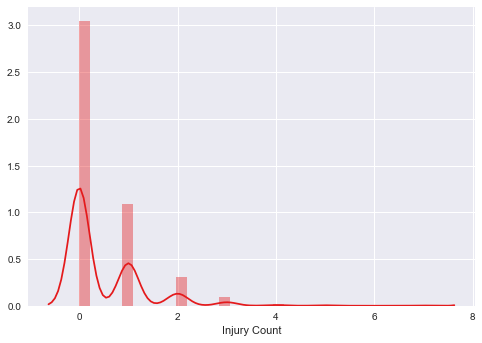

In [96]:
# Plot the distribution of number of injuries

sns.distplot(new_df['Injury Count'])

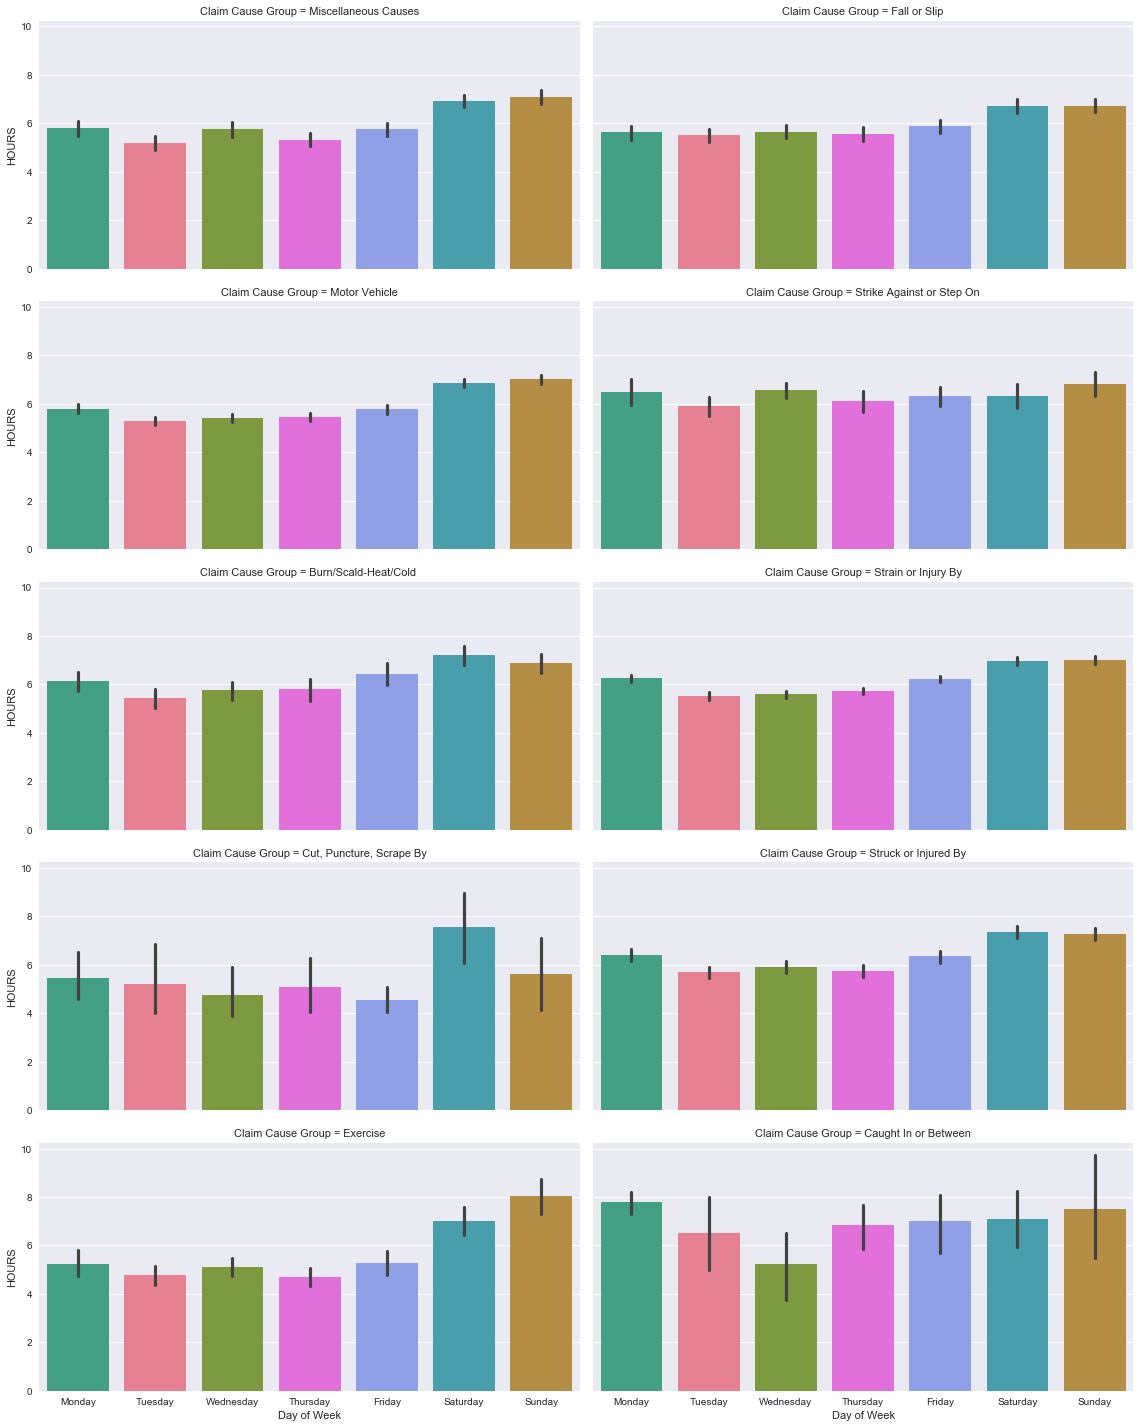

In [97]:
# Overtime usage habits for different Claim Causes by Day of Week 

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
OT_filtered = injured_df[injured_df['VAR_CODE'].isin(OT_safe)]
g = sns.FacetGrid(OT_filtered, col="Claim Cause Group", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

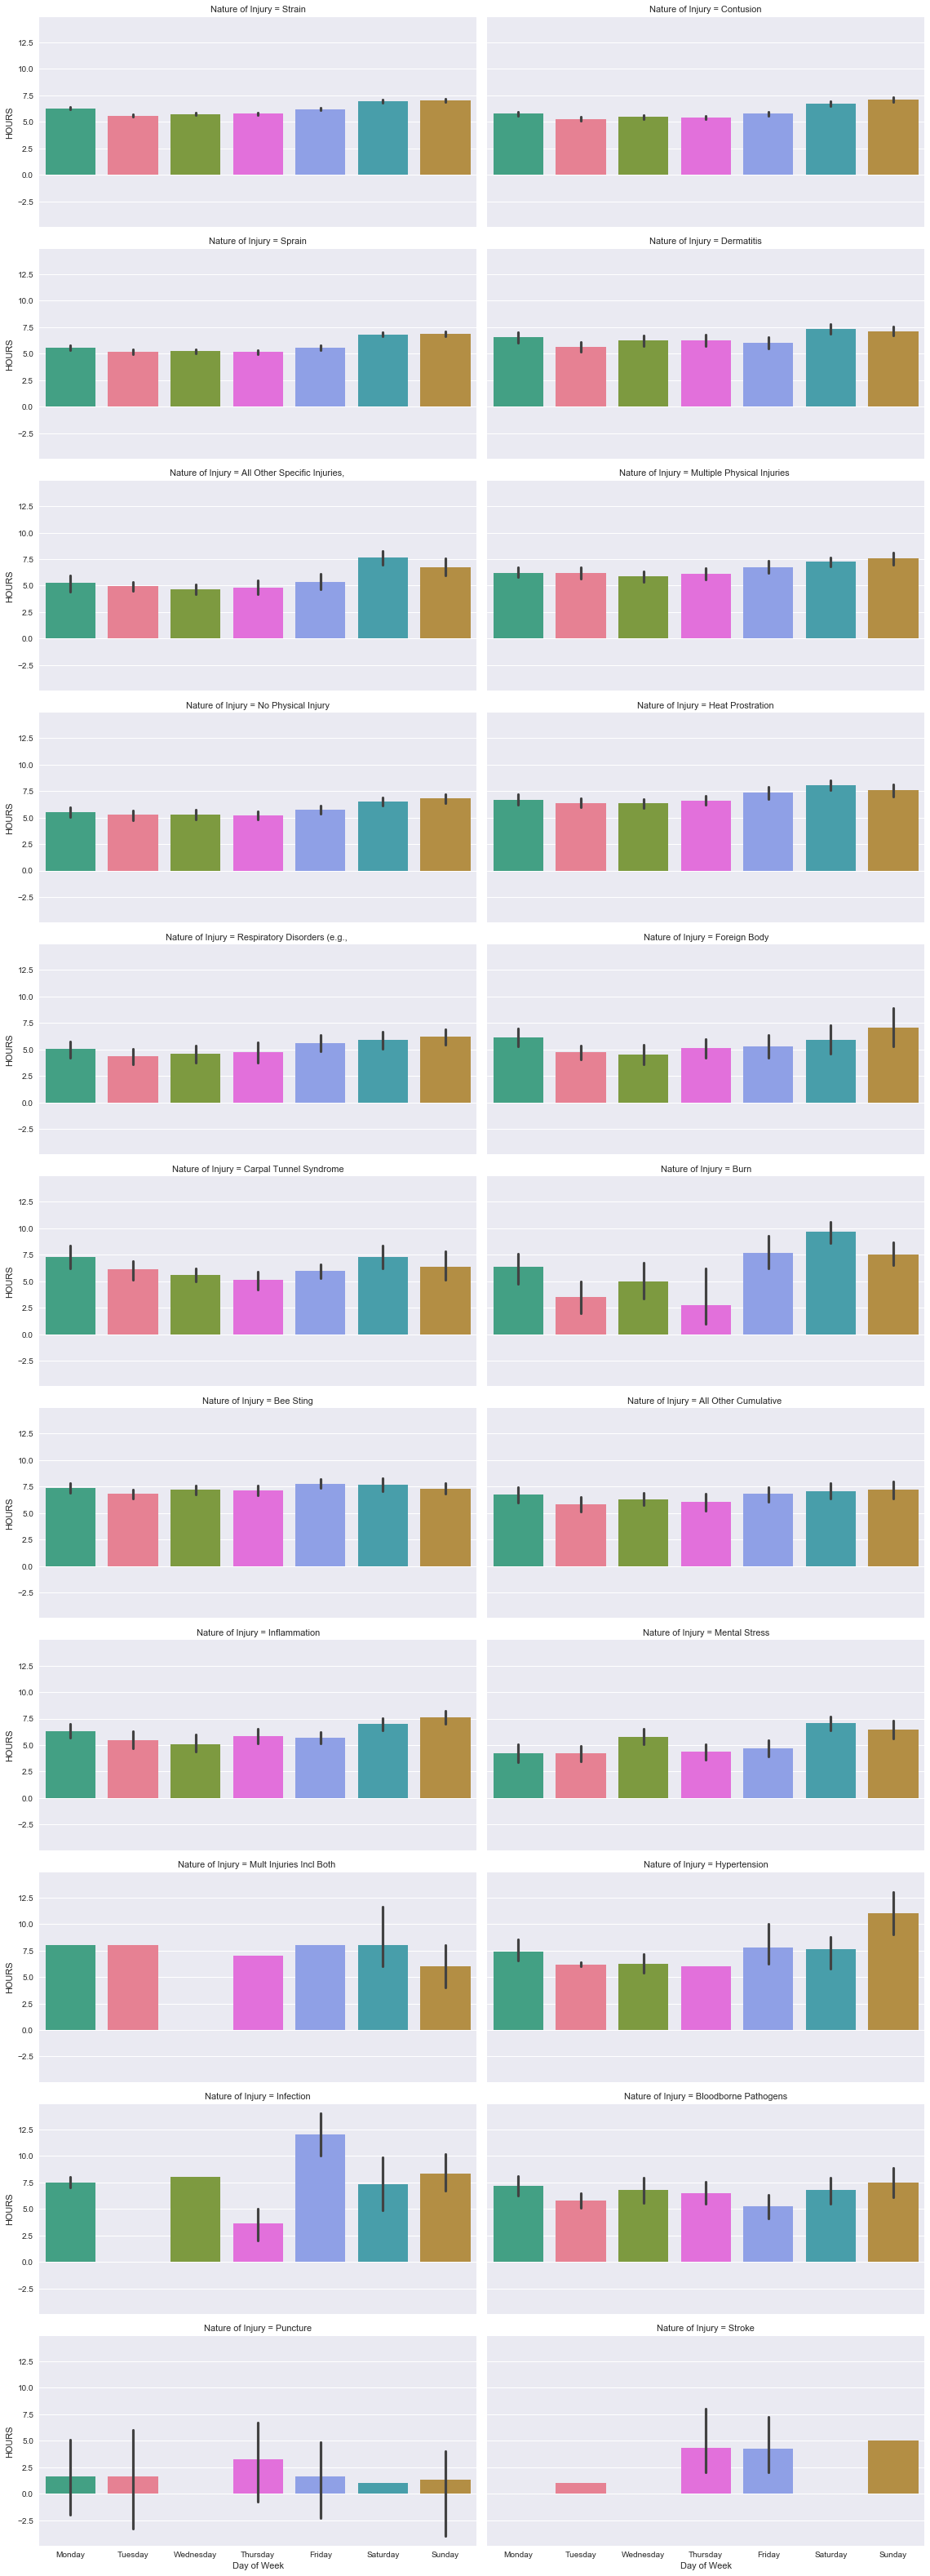

In [98]:
# Overtime usage habits for different types of injury by Day of Week 

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
OT_filtered = injured_df[injured_df['VAR_CODE'].isin(OT_safe)]
g = sns.FacetGrid(OT_filtered, col="Nature of Injury", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

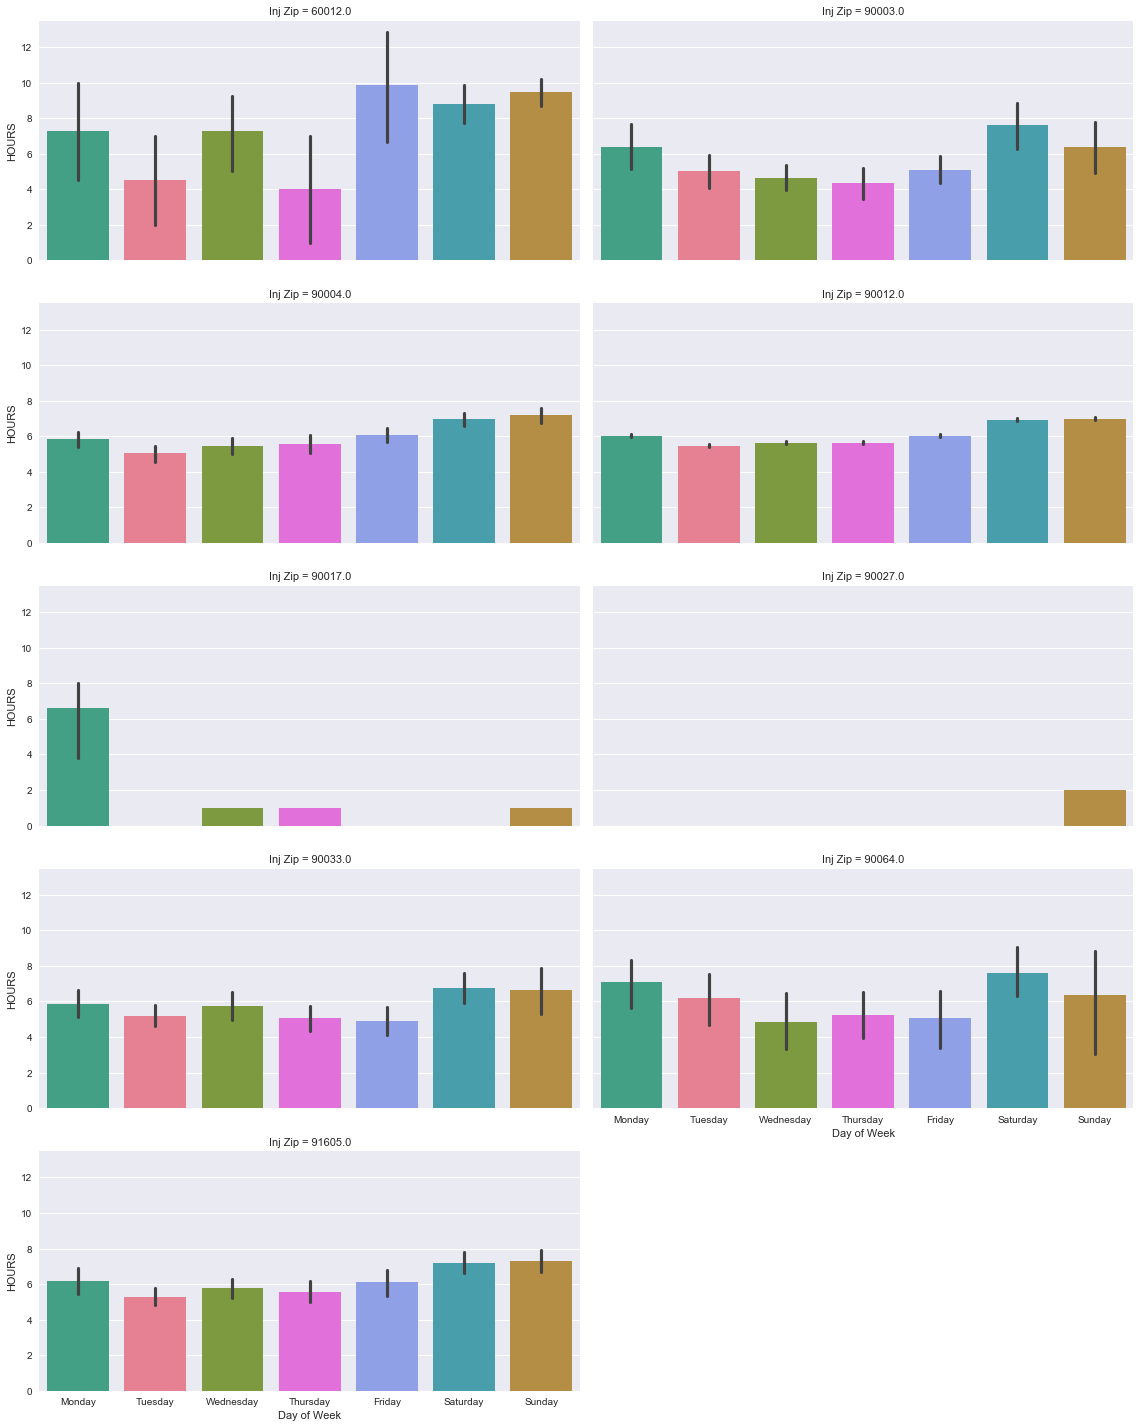

In [99]:
# Overtime usage habits for different Injury Zip Codes by Day of Week 

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
OT_filtered = injured_df[injured_df['VAR_CODE'].isin(OT_safe)]
g = sns.FacetGrid(OT_filtered, col="Inj Zip", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

In [100]:
# Show the count of injuries that occurred in different zip codes

test_df = injured_df[injured_df['WORK_DATE']== injured_df['DOI']]

inj_zip_grouped= test_df.groupby('Inj Zip')['DOI'].count()
inj_zip_grouped

Inj Zip
60012.0      2
90003.0      4
90004.0     21
90012.0    378
90017.0      1
90027.0      2
90033.0      4
90064.0      2
91605.0      9
Name: DOI, dtype: int64

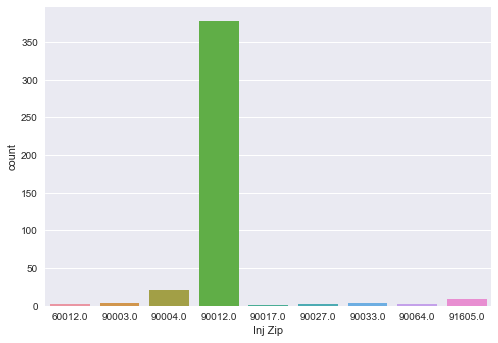

In [101]:
# Graph unique injuries by zip code

sns_plot = sns.countplot(x = 'Inj Zip', data = test_df)

In [102]:
# Var codes that have Negative hour values by percentage of total count

pct_func = lambda x: (x *100) / x.sum()

neg_hours_df = injured_df[injured_df['HOURS']<0]

neg_hrs_grouped = neg_hours_df.groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['EMPLOYEE_NAME'].count().sort_values(ascending = False)
neg_hrs_grouped.transform(pct_func).head(20)

VAR_CODE  VARIATION_DESCRIPTION                             
AR        ADJUSTMENT PERMANENT VARIATION IN RATE                39.217398
SK        100% SICK TIME (CREDIT OR CHARGE)                     12.778792
VC        VACATION (POS AND NEG)                                 7.548218
NP        NEW HIRE CODE / HOURS NO PAY IN INITIAL PAY PERIOD     7.071990
8A        ABSENT WITHOUT PAY - SICK LEAVE                        5.444877
SS        75%  SICK TIME (CREDIT OR CHARGE)                      4.968648
HW        CURRENT ACTUAL HOURS WORKED ONLY                       4.524169
PA        OVERTIME (1.5) WORKED AND PAID                         4.460671
HO        HOLIDAY HOURS (CREDIT OR CHARGE)                       2.889118
IS        NET IOD (POS OR NEG)                                   1.603302
L2        ADMINISTRATIVE LEAVE WITH PAY (POS OR NEG)             1.285816
FI        FAMILY ILLNESS (POS OR NEG)                            1.023891
OM        ADJUST VC MAX BALANCE (-) WAIVED         

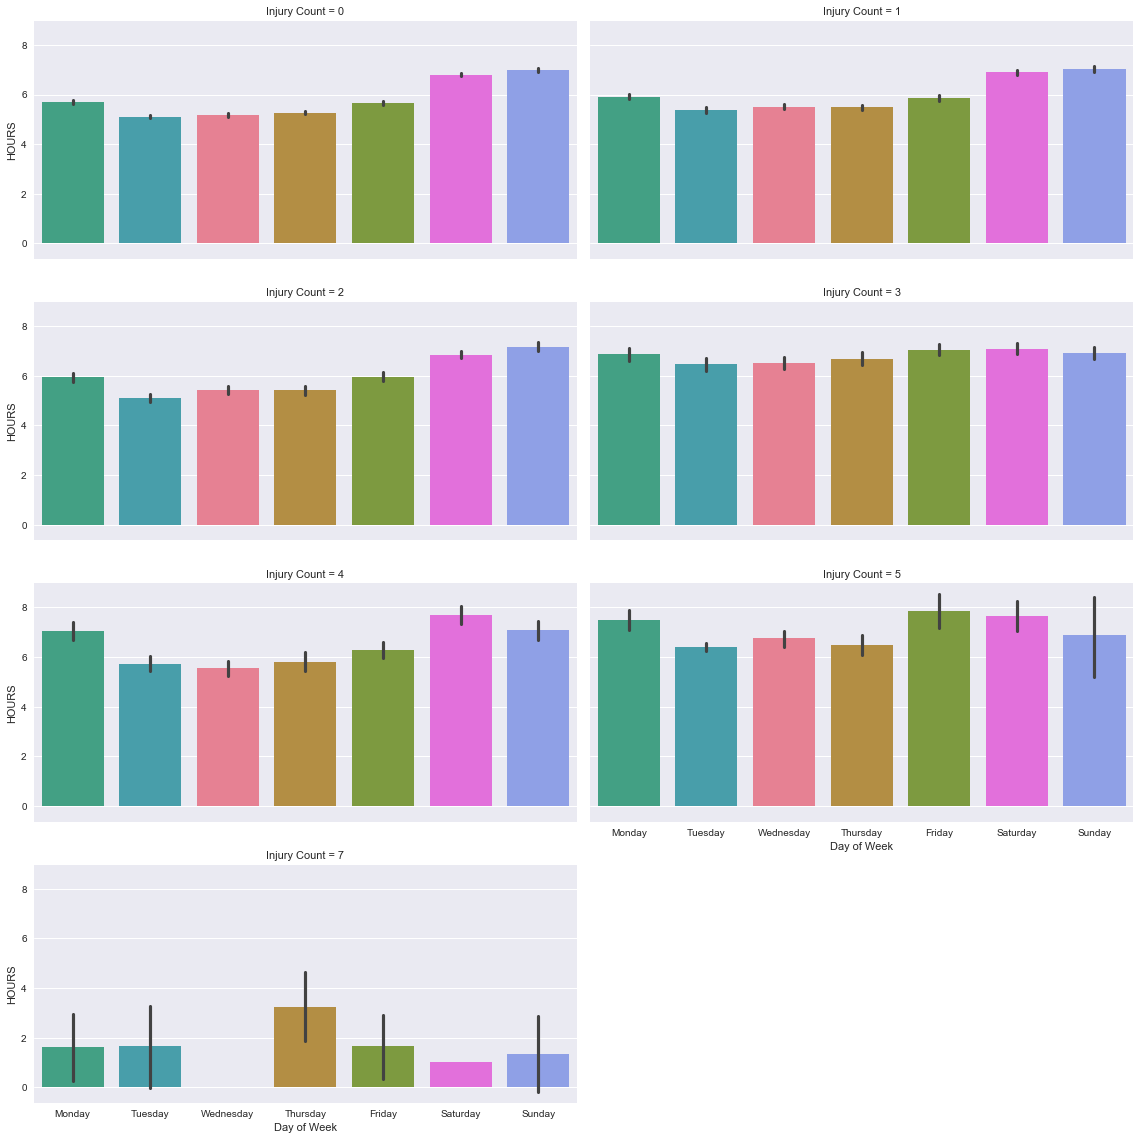

In [103]:
# Overtime usage habits for employee Injury Count groups by Day of Week 

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
OT_filtered = best_df[best_df['VAR_CODE'].isin(OT_safe)]
g = sns.FacetGrid(OT_filtered, col="Injury Count", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

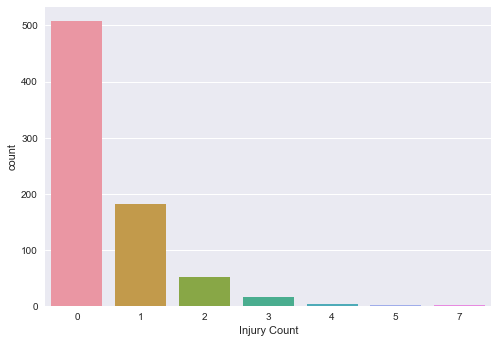

In [104]:
# Graph the size of each injury count group

sns_plot = sns.countplot(x = 'Injury Count', data = new_df)

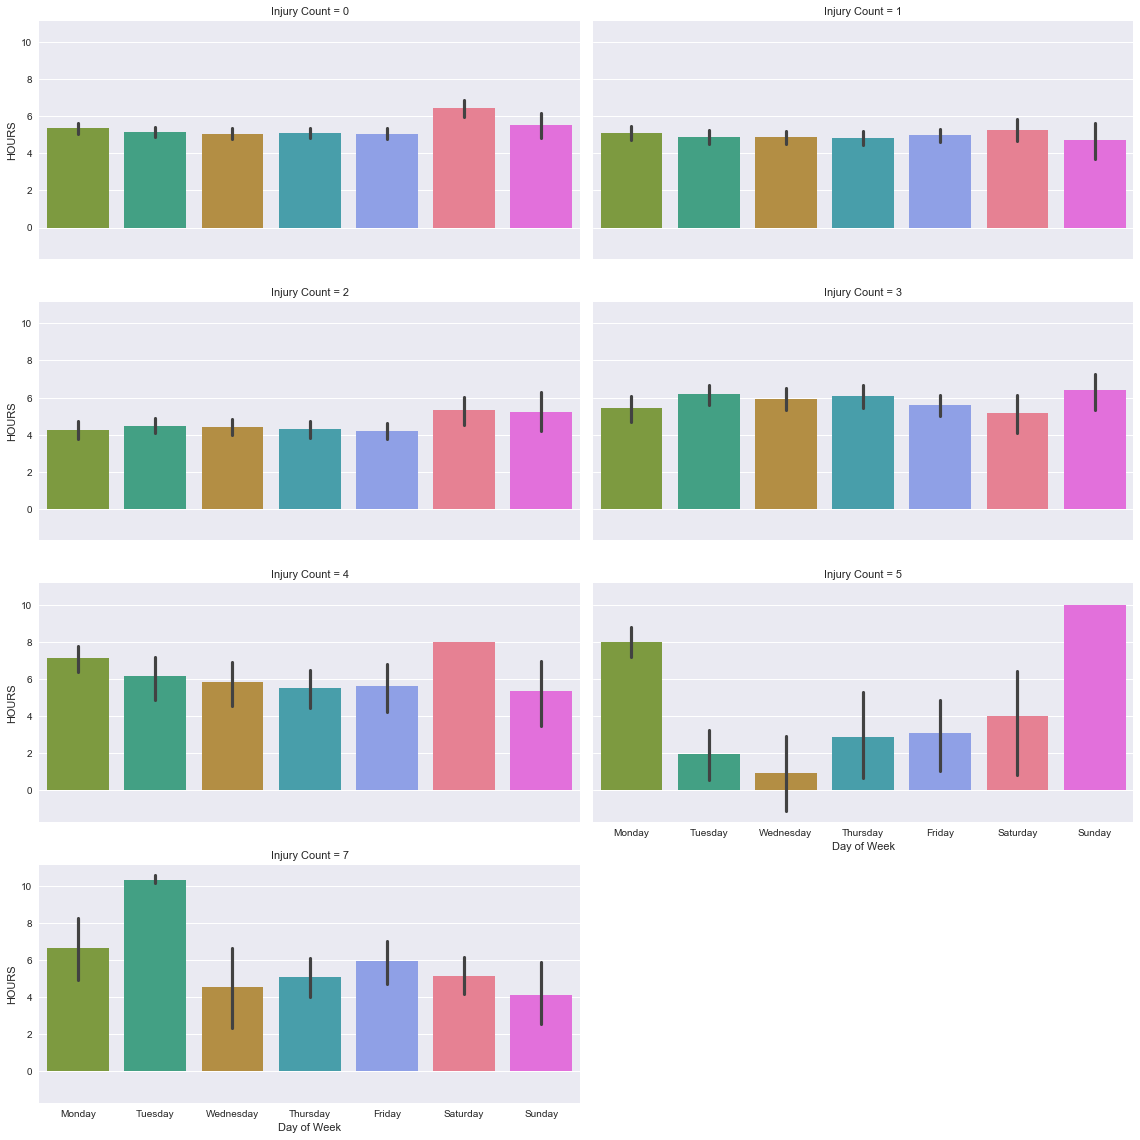

In [105]:
# Sick time usage habits for employee Injury Count groups by Day of Week 

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sick_filtered = best_df[best_df['VAR_CODE'].isin(sick_safe)]
g = sns.FacetGrid(sick_filtered, col="Injury Count", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

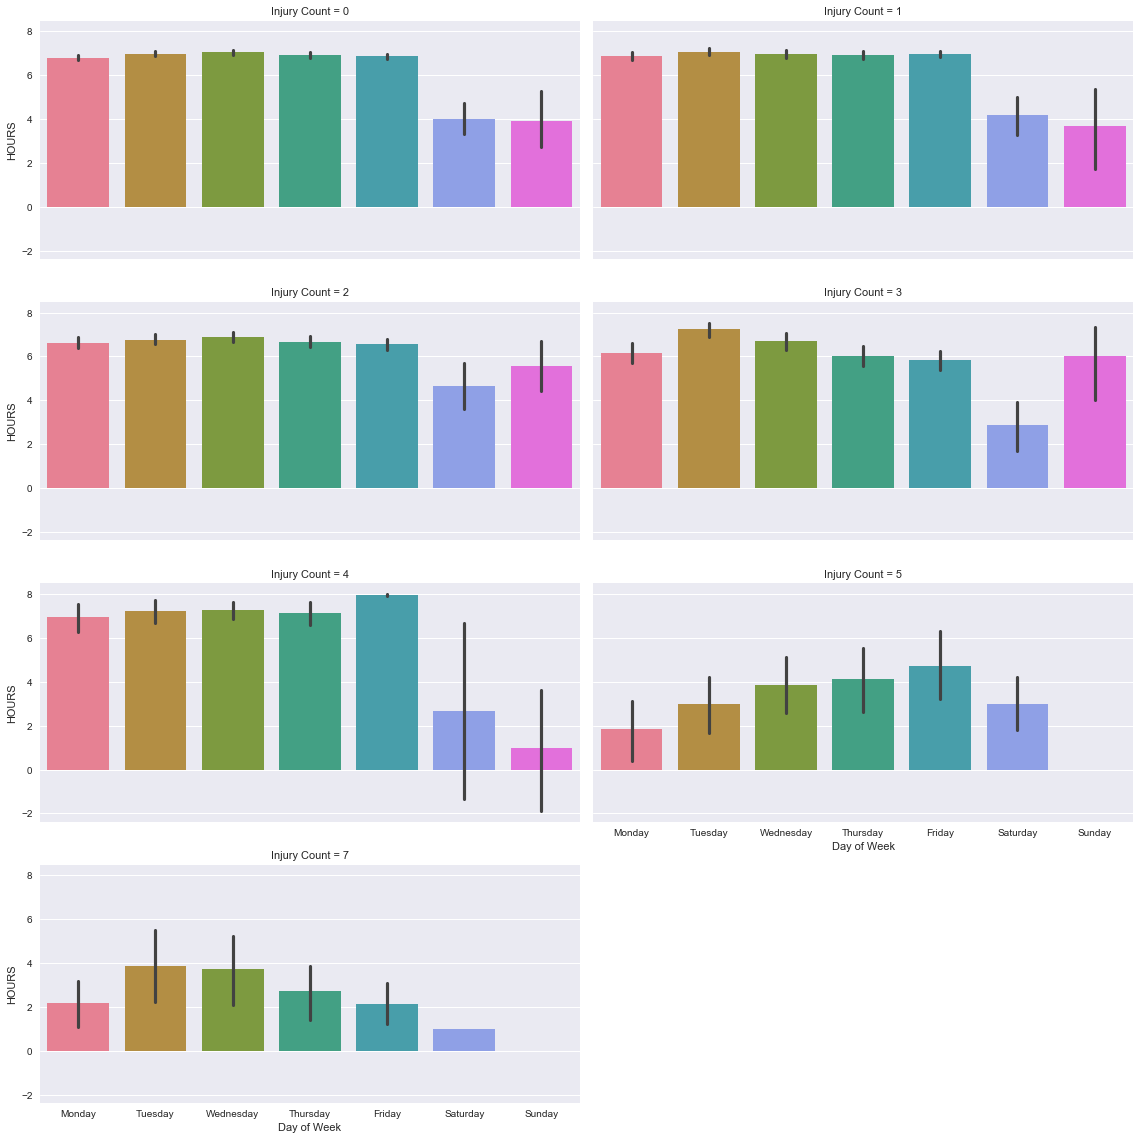

In [106]:
# Vacation time usage habits for employee Injury Count groups by Day of Week 

vacation_filtered = best_df[best_df['VAR_CODE'].isin(vacation_safe)]
g = sns.FacetGrid(vacation_filtered, col="Injury Count", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

In [107]:
# Most common days of the week for injury, from most to least
mikes_test = injured_df[injured_df['WORK_DATE']== injured_df['DOI']]

counts = mikes_test['Day of Week'].value_counts().index.tolist()
counts

['Thursday', 'Tuesday', 'Wednesday', 'Monday', 'Friday', 'Saturday', 'Sunday']

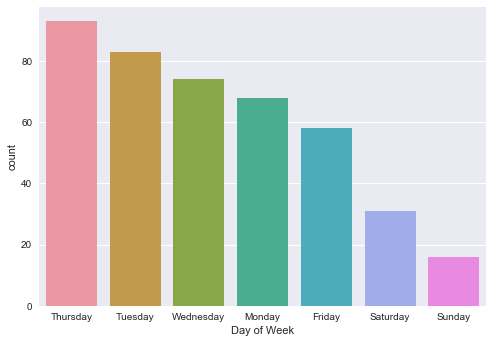

In [108]:
# Graph the the number of injuries for each day of the week, from most to least

sns_plot = sns.countplot(x = 'Day of Week', data = mikes_test, order = counts)

In [109]:
# Functions to create time series for specific types of variation codes, grouped by day and backfilled
# First function aggregated by mean, second by total

def clean_for_var_time_mean(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'HOURS': 'mean'})
    return new_df.asfreq("D", method='bfill')

def clean_for_var_time_total(df, var_list):
    new_df = df[df['VAR_CODE'].isin(var_list)].reset_index(drop=True)
    new_df = new_df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'HOURS': 'sum'})
    return new_df.asfreq("D", method='bfill')


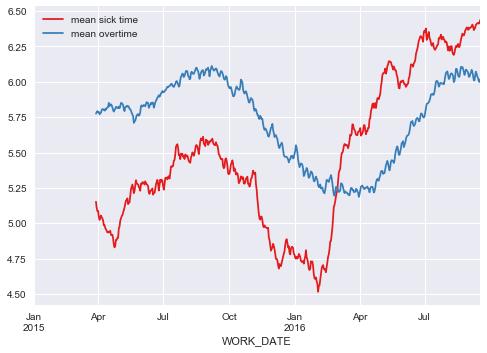

In [110]:
# 88-day moving average for mean sick time and mean overtime
# Notice they seem to follow each other
sns.set_palette("Set1")

test_data = joined_df
# test_data = joined_df.sample(frac = .1)
sick_filtered_mean = clean_for_var_time_mean(test_data, sick_safe)
OT_filtered_mean = clean_for_var_time_mean(test_data, OT_safe)
vacation_filtered_mean = clean_for_var_time_mean(test_data, vacation_safe)
# RT_filtered = clean_for_var_time(joined_df, RT_var_codes)

fig, ax = plt.subplots()
sick_filtered_mean['2015':'2016'].rolling(88).mean().plot(ax = ax, label = 'sick time')
OT_filtered_mean['2015':'2016'].rolling(88).mean().plot(ax = ax, label = 'overtime')
# vacation_filtered_mean['2015':'2016'].rolling(30).mean().plot(ax = ax, label = 'vacation time')
# RT_filtered['Sep 2015':'September 2016'].rolling(7).mean().plot(ax = ax, label = 'regular time')
ax.legend(['mean sick time', 'mean overtime'])

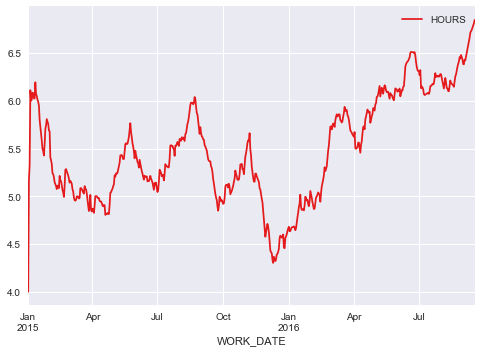

In [111]:
# Exponentially weighted moving average for mean sick time
# Notice the 3 month cycles, particularly from April 2015 to January 2016
sick_filtered_mean['2015':'2016'].ewm(alpha=0.03).mean().plot()

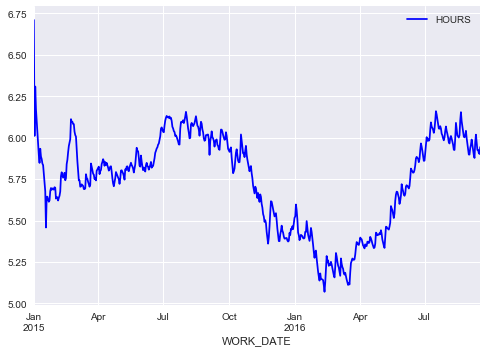

In [112]:
# Exponentially weighted moving average for mean overtime
OT_filtered_mean['2015':'2016'].ewm(alpha=0.03).mean().plot(color = 'b')

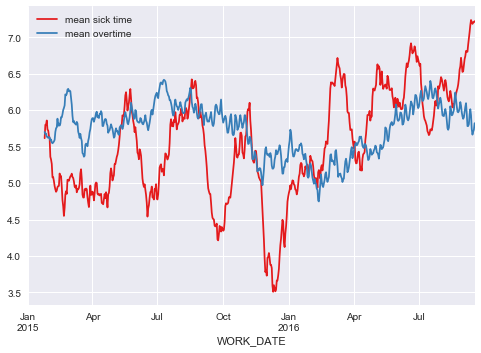

In [113]:
# Overlaid graph of the 24 day moving average for mean overtime with the 24 day moving overage of mean sick time
# Notice that the periods of sick time seem in sync with the trend of overtime

fig, ax = plt.subplots()
sick_filtered_mean['2015':'2016'].rolling(24).mean().plot(ax = ax, label = 'sick time')
OT_filtered_mean['2015':'2016'].rolling(24).mean().plot(ax = ax, label = 'overtime')
# vacation_filtered_mean['2015':'2016'].rolling(30).mean().plot(ax = ax, label = 'vacation time')
# RT_filtered['Sep 2015':'September 2016'].rolling(7).mean().plot(ax = ax, label = 'regular time')
ax.legend(['mean sick time', 'mean overtime'])

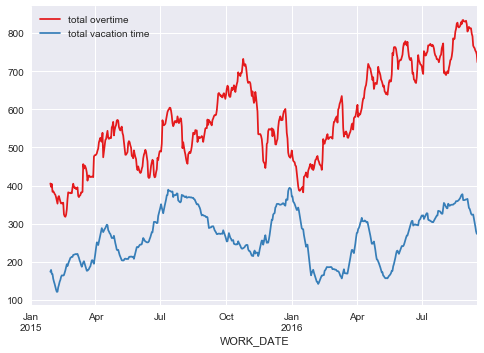

In [114]:
# Overlaid graph of the 28 day moving average for total overtime with the 28 day moving overage of total vacation sick time 
# Notice that both time series seem to be in synch with each other

test_data = joined_df
# test_data = joined_df.sample(frac = .1)

sick_filtered_total = clean_for_var_time_total(test_data, sick_safe)
OT_filtered_total = clean_for_var_time_total(test_data, OT_safe)
vacation_filtered_total = clean_for_var_time_total(test_data, vacation_safe)

fig, ax = plt.subplots()
# sick_filtered_total['2015':'2016'].rolling(30).mean().plot(ax = ax, label = 'sick time')
OT_filtered_total['2015':'2016'].rolling(28).mean().plot(ax = ax, label = 'overtime')
vacation_filtered_total['2015':'2016'].rolling(28).mean().plot(ax = ax, label = 'vacation time')
# RT_filtered['Sep 2015':'September 2016'].rolling(7).mean().plot(ax = ax, label = 'regular time')
ax.legend(['total overtime', 'total vacation time'])

In [115]:
# Save each filtered time series 

sick_filtered_mean.to_csv('C:\\Users\\382365\\Documents\\sick_mean.csv')
OT_filtered_mean.to_csv('C:\\Users\\382365\\Documents\\OT_mean.csv')
vacation_filtered_mean.to_csv('C:\\Users\\382365\\Documents\\vacation_mean.csv')

sick_filtered_total.to_csv('C:\\Users\\382365\\Documents\\sick_total.csv')
OT_filtered_total.to_csv('C:\\Users\\382365\\Documents\\OT_total.csv')
vacation_filtered_total.to_csv('C:\\Users\\382365\\Documents\\vacation_total.csv')

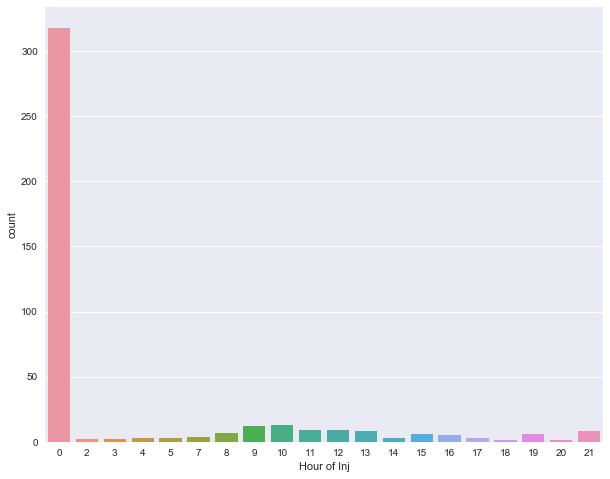

In [116]:
# Most common times for injury

mikes_test['Hour of Inj'] = mikes_test['Time of Inj'].dt.hour

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns_plot = sns.countplot(x = 'Hour of Inj', data = mikes_test, ax = ax)

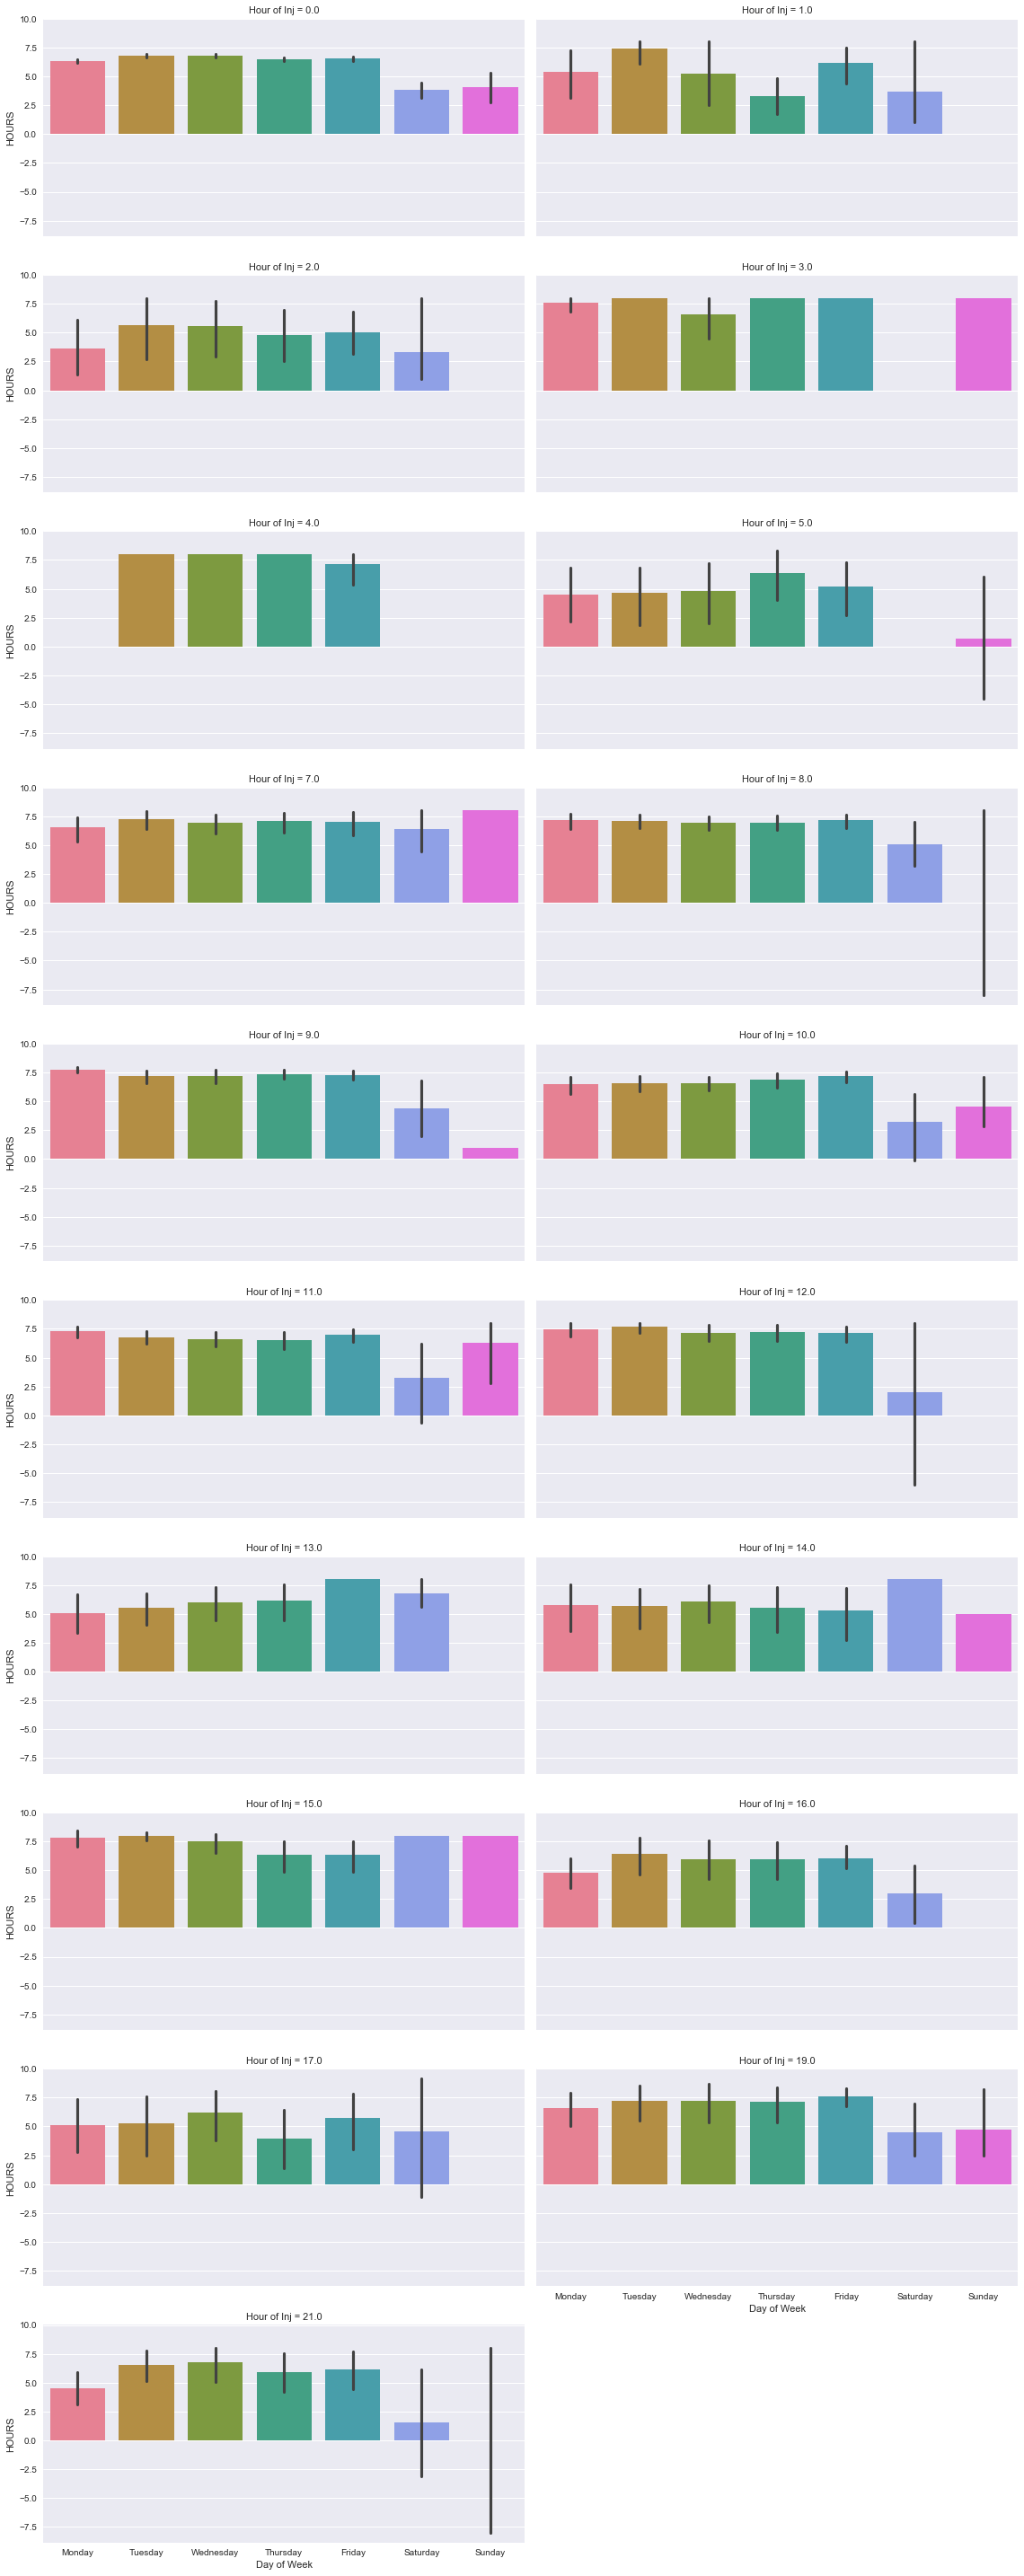

In [117]:
# Vacation time usage habits for different Hours of Injury groups by Day of Week 

best_df['Hour of Inj'] = best_df['Time of Inj'].dt.hour
vacation_filtered = best_df[best_df['VAR_CODE'].isin(vacation_safe)]
g = sns.FacetGrid(vacation_filtered, col="Hour of Inj", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

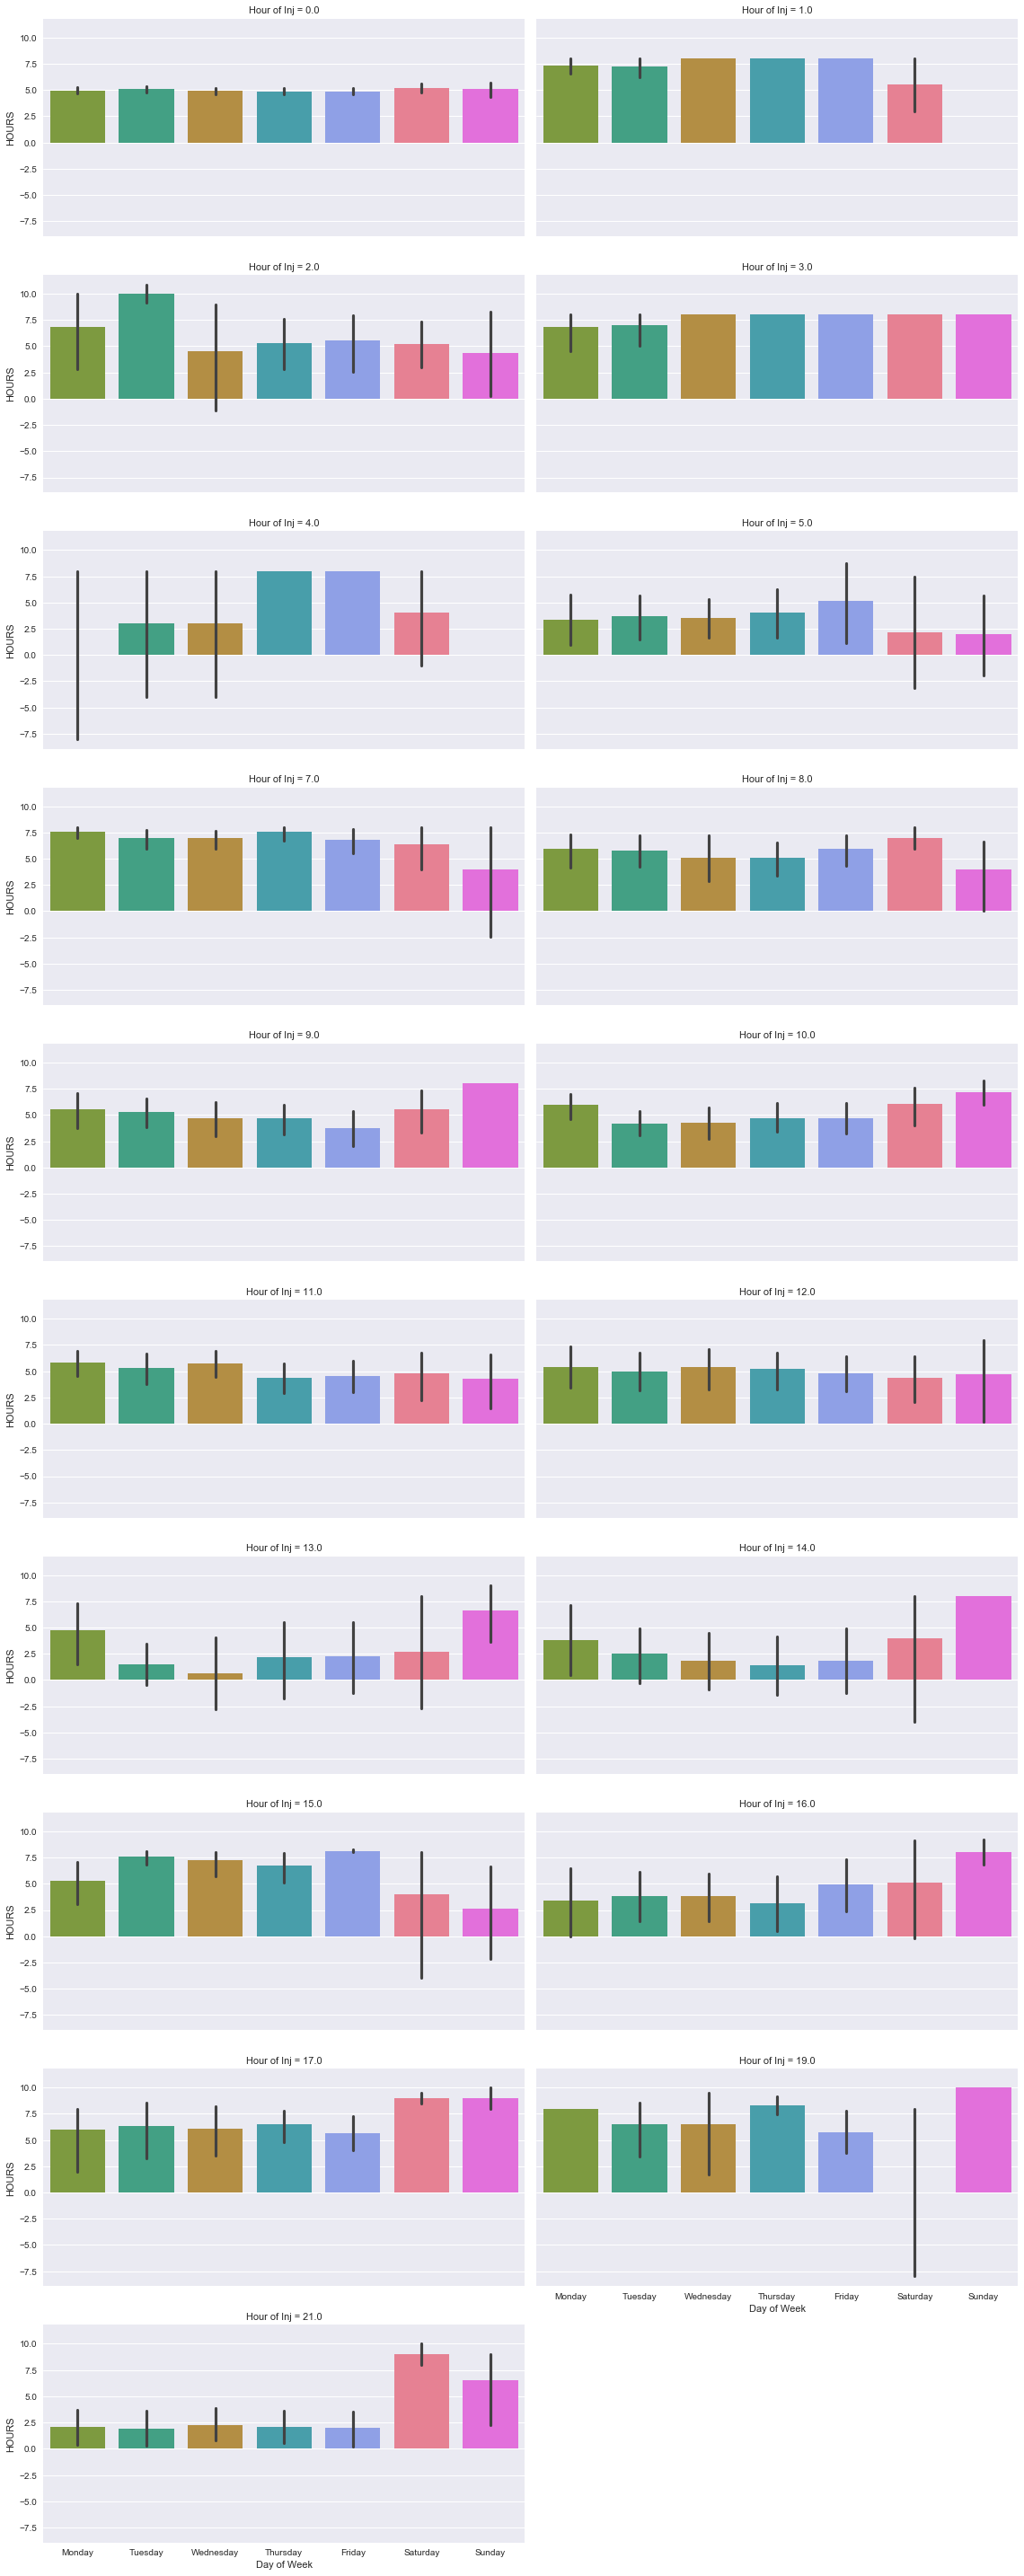

In [118]:
# Sick time usage habits for different Hours of Injury groups by Day of Week 

sick_filtered = best_df[best_df['VAR_CODE'].isin(sick_safe)]
g = sns.FacetGrid(sick_filtered, col="Hour of Inj", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

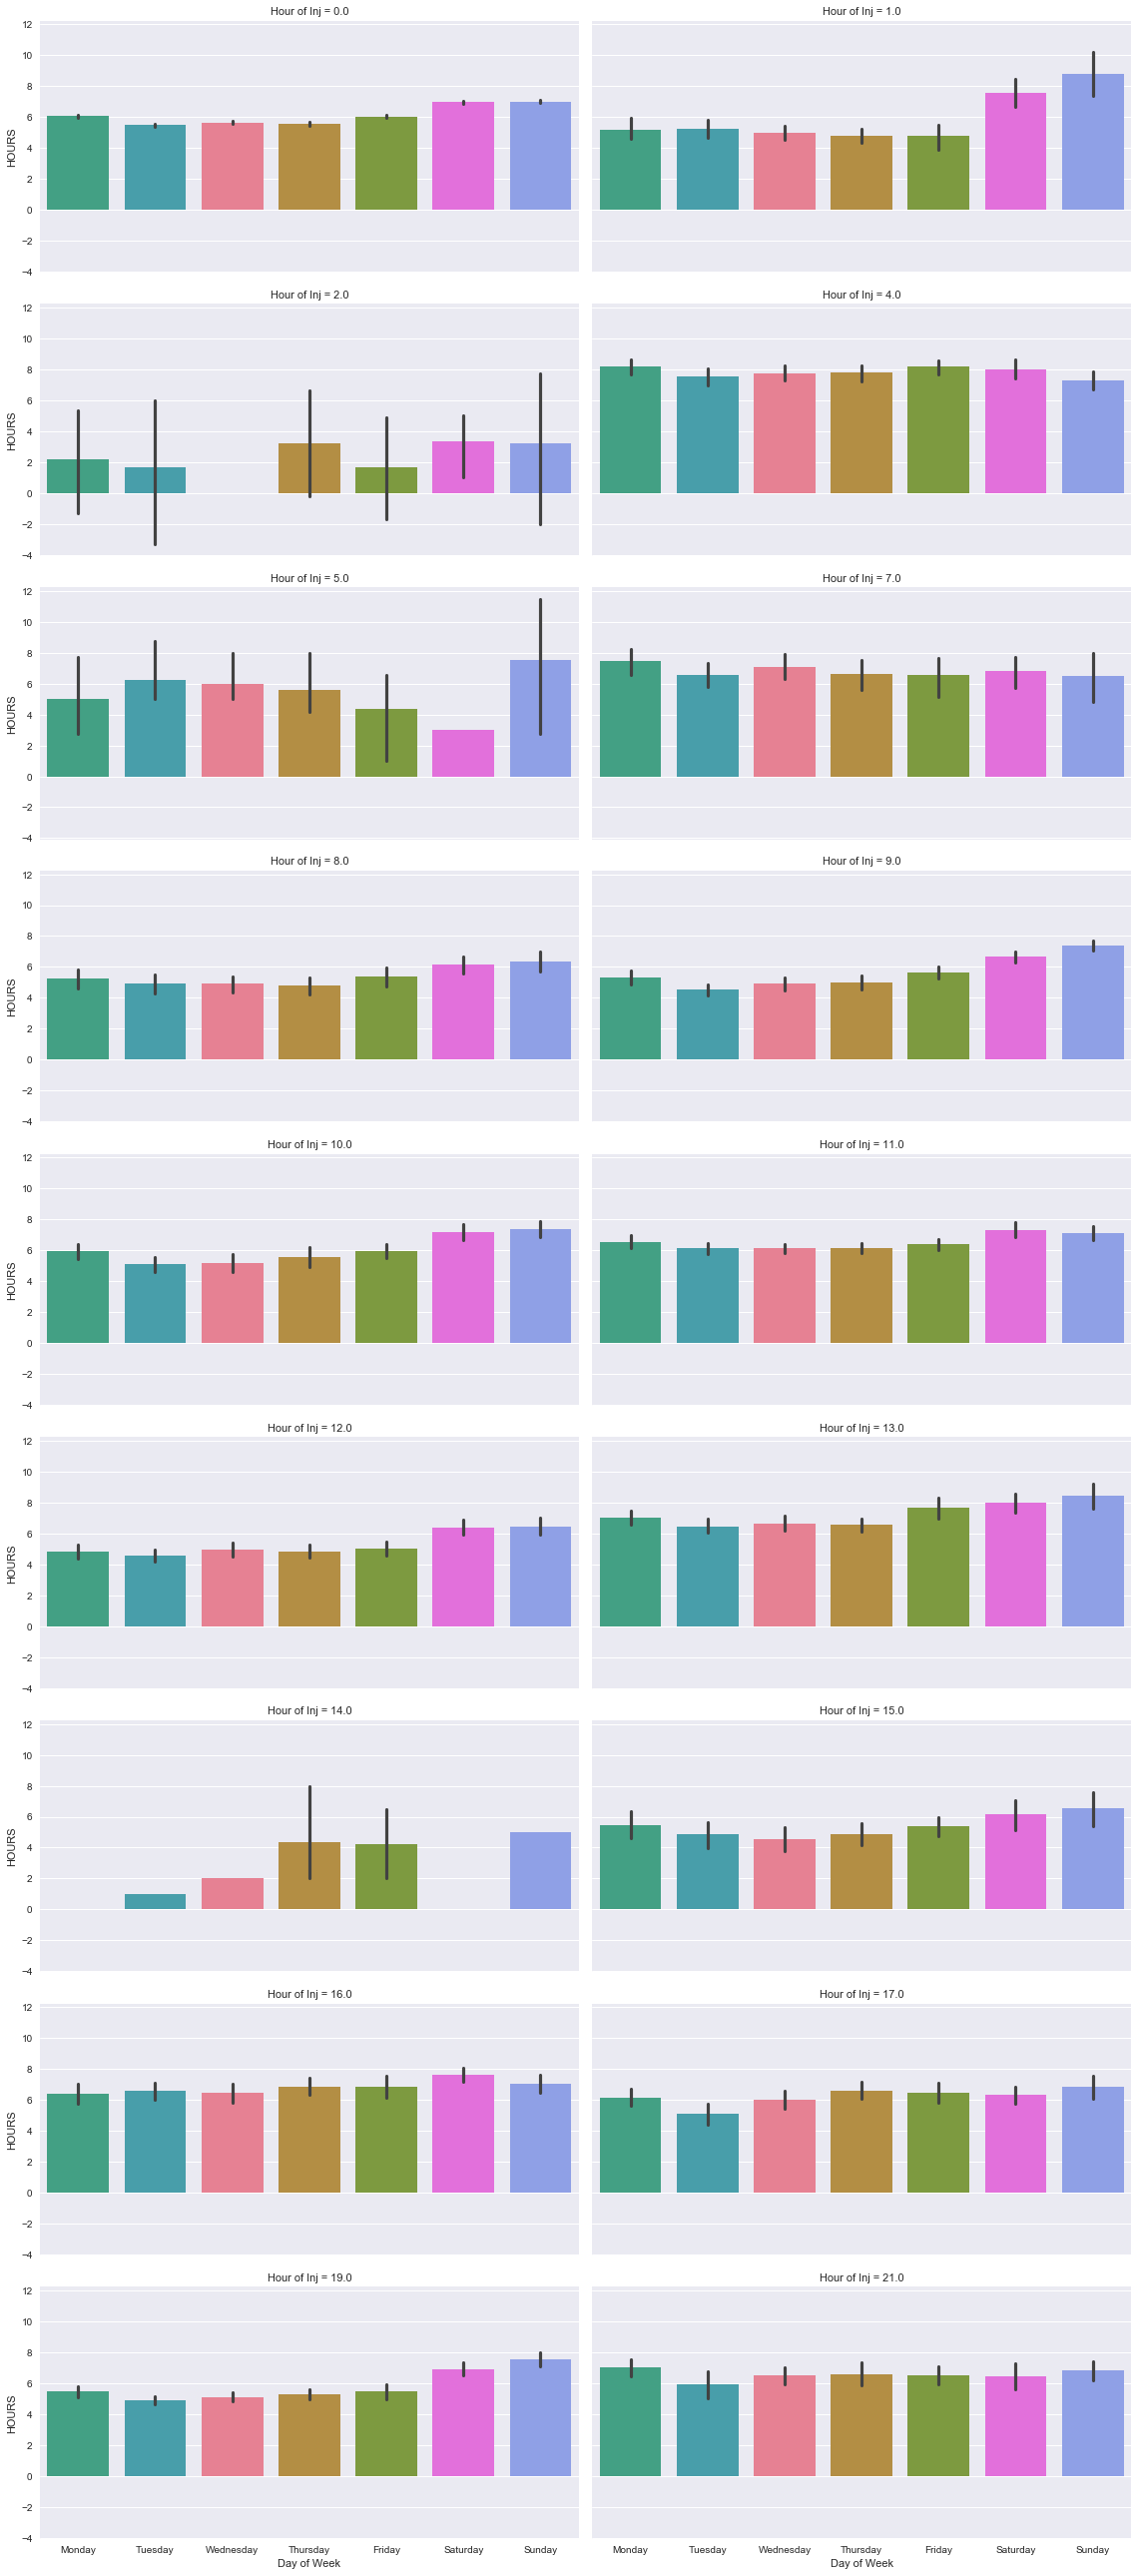

In [119]:
# Sick time usage habits for different Hours of Injury groups by Day of Week  

OT_filtered = best_df[best_df['VAR_CODE'].isin(OT_safe)]
g = sns.FacetGrid(OT_filtered, col="Hour of Inj", hue="Day of Week", size=4, aspect = 2, col_wrap=2)
sns_plot = g.map(sns.barplot,'Day of Week','HOURS', order = weekdays)

In [120]:
# Most common (by counts of times it appears on a workdate in dataframe) variation codes

best_df.groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['WORK_DATE'].count().sort_values(ascending = False).head(30)

VAR_CODE  VARIATION_DESCRIPTION                             
HW        CURRENT ACTUAL HOURS WORKED ONLY                      295753
PA        OVERTIME (1.5) WORKED AND PAID                         76683
UA        UNIFORM ALLOWANCE                                      43385
VC        VACATION (POS AND NEG)                                 30361
IS        NET IOD (POS OR NEG)                                   25022
HO        HOLIDAY HOURS (CREDIT OR CHARGE)                       16344
AR        ADJUSTMENT PERMANENT VARIATION IN RATE                 15465
SK        100% SICK TIME (CREDIT OR CHARGE)                      14883
LD        LIGHT DUTY RETURN TO WORK PROGRAM                       6453
TX        TRAVEL ALLOWANCE                                        6001
SS        75%  SICK TIME (CREDIT OR CHARGE)                       5795
8A        ABSENT WITHOUT PAY - SICK LEAVE                         5256
FI        FAMILY ILLNESS (POS OR NEG)                             4741
TU        TEMPOR

In [121]:
# Unique job class titles in the dataset

joined_df['JOB_CLASS_TITLE'].unique()

array(['TRAF OFFICER I', 'TRAF OFFICER II'], dtype=object)

In [122]:
# Best paid days of the week for overtime by quarter and fiscal year, in descending order

joined_df[joined_df['VAR_CODE'].isin(OT_safe)].groupby(['PAYROLL_YEAR', 'Quarter', 'Day of Week'])['PAY_AMOUNT']\
    .sum().sort_values(ascending = False).head(50)

PAYROLL_YEAR  Quarter  Day of Week
2016-17       Q1       Saturday       548334
2015-16       Q1       Saturday       517622
              Q2       Saturday       510979
2014-15       Q1       Saturday       505516
2015-16       Q4       Saturday       491426
2016-17       Q1       Friday         456839
2014-15       Q2       Sunday         449085
                       Saturday       444864
2016-17       Q1       Sunday         441303
2015-16       Q2       Sunday         436255
              Q4       Friday         425387
2014-15       Q1       Friday         412561
                       Sunday         405704
2015-16       Q4       Monday         383818
              Q2       Friday         381438
              Q4       Tuesday        378622
                       Sunday         367714
              Q3       Monday         365363
              Q1       Sunday         363556
2014-15       Q2       Friday         358460
2015-16       Q3       Sunday         348477
              Q1    

In [123]:
# Most paid days of the week for regular time by quarter, in descending order

daysgrouped = joined_df[(joined_df['VAR_CODE'].isin(RT_var_codes)) & (joined_df['WORK_DATE']>'2015-6-30')].\
    groupby(['Quarter', 'Day of Week'])['PAY_AMOUNT'].sum()

daysgrouped

Quarter  Day of Week
Q1       Friday         2289670
         Monday         2071768
         Saturday       1185556
         Sunday          604765
         Thursday       2549311
         Tuesday        2605841
         Wednesday      2655747
Q2       Friday         1053249
         Monday         1171263
         Saturday        613826
         Sunday          322314
         Thursday       1330928
         Tuesday        1378577
         Wednesday      1236908
Q3       Friday         1216364
         Monday         1027970
         Saturday        635301
         Sunday          309851
         Thursday       1433211
         Tuesday        1474156
         Wednesday      1428317
Q4       Friday         1250876
         Monday         1210144
         Saturday        613434
         Sunday          321871
         Thursday       1396913
         Tuesday        1434060
         Wednesday      1413194
Name: PAY_AMOUNT, dtype: int64

In [124]:
# Most paid days of the week for regular time by quarter, in descending order, by percent of total

daysgrouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

Quarter  Day of Week
Q1       Friday         16.398525
         Monday         14.837920
         Saturday        8.490905
         Sunday          4.331303
         Thursday       18.258064
         Tuesday        18.662929
         Wednesday      19.020354
Q2       Friday         14.819746
         Monday         16.480263
         Saturday        8.636842
         Sunday          4.535121
         Thursday       18.726830
         Tuesday        19.397276
         Wednesday      17.403921
Q3       Friday         16.163940
         Monday         13.660422
         Saturday        8.442347
         Sunday          4.117528
         Thursday       19.045563
         Tuesday        19.589670
         Wednesday      18.980528
Q4       Friday         16.371668
         Monday         15.838561
         Saturday        8.028724
         Sunday          4.212700
         Thursday       18.283024
         Tuesday        18.769210
         Wednesday      18.496113
Name: PAY_AMOUNT, dtype: fl

In [125]:
# Number of injured, not injured

len(injured_list), len(not_injured_list)

(254, 508)

In [126]:
# Day of the week with most overtime hours for injured employees

joined_df[joined_df['EMPLOYEE_NAME'].isin(injured_list) & joined_df['VAR_CODE'].isin(OT_safe)].groupby(['Day of Week'])\
    ['HOURS'].sum().sort_values(ascending=False)

Day of Week
Saturday     40327
Sunday       35417
Friday       33528
Monday       28090
Wednesday    25674
Thursday     25597
Tuesday      24732
Name: HOURS, dtype: int64

In [127]:
#  Day of the week with most overtime hours for un-injured employees

joined_df[joined_df['EMPLOYEE_NAME'].isin(not_injured_list) & joined_df['VAR_CODE'].isin(OT_safe)].groupby(['Day of Week'])\
    ['HOURS'].sum().sort_values(ascending=False)

Day of Week
Saturday     47501
Sunday       44921
Friday       38654
Monday       31619
Thursday     29422
Wednesday    28760
Tuesday      27851
Name: HOURS, dtype: int64

In [128]:
# Most common (by amount of total pay in dataframe) variation codes

joined_df[joined_df['EMPLOYEE_NAME'].isin(injured_list)].groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])\
    ['PAY_AMOUNT'].sum().sort_values(ascending = False).head(25)
    

VAR_CODE  VARIATION_DESCRIPTION                       
HW        CURRENT ACTUAL HOURS WORKED ONLY                30798705
PA        OVERTIME (1.5) WORKED AND PAID                   9223469
IS        NET IOD (POS OR NEG)                             3828114
VC        VACATION (POS AND NEG)                           3199429
HO        HOLIDAY HOURS (CREDIT OR CHARGE)                 1804761
SK        100% SICK TIME (CREDIT OR CHARGE)                1282314
UA        UNIFORM ALLOWANCE                                1001620
LD        LIGHT DUTY RETURN TO WORK PROGRAM                 945864
FI        FAMILY ILLNESS (POS OR NEG)                       553934
TU        TEMPORARY VARIATION IN RATE - UP                  461952
SS        75%  SICK TIME (CREDIT OR CHARGE)                 433155
FH        FLOATING HOLIDAY HOURS TAKEN THIS PAY PERIOD      321722
L2        ADMINISTRATIVE LEAVE WITH PAY (POS OR NEG)        227138
TO        OVERTIME TAKEN OFF  (1.5)                         176924
F4     

In [129]:
# Most common days of injury by listed date(DOI) and day of week in descending order

joined_df[joined_df['EMPLOYEE_NAME'].isin(injured_list)].groupby(['Day of Week', 'DOI'])\
    ['EMPLOYEE_NAME'].nunique().sort_values(ascending = False).head(25)

Day of Week  DOI       
Friday       2016-01-13    5
Tuesday      2016-01-13    5
Wednesday    2016-01-13    5
Monday       2016-01-13    5
Saturday     2016-01-13    5
Thursday     2016-01-13    5
Sunday       2016-01-13    4
Friday       2016-05-05    3
Sunday       2015-10-20    3
Friday       2015-07-09    3
Wednesday    2015-03-26    3
Friday       2015-07-06    3
             2015-03-26    3
             2015-06-30    3
Tuesday      2015-10-20    3
Monday       2015-12-14    3
Saturday     2015-07-24    3
Wednesday    2016-03-23    3
Monday       2016-03-23    3
Thursday     2015-03-26    3
Friday       2016-03-23    3
Saturday     2015-07-09    3
Tuesday      2015-12-14    3
Friday       2016-03-31    3
Saturday     2016-05-05    3
Name: EMPLOYEE_NAME, dtype: int64

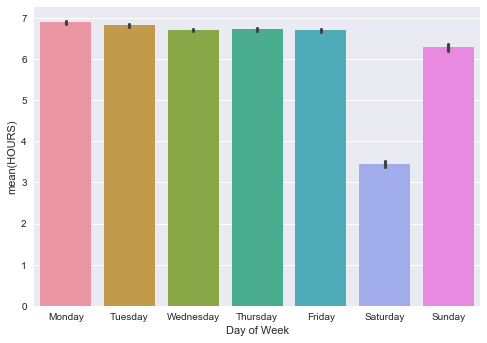

In [130]:
# Mean number of hours worked by day of week for injured workers

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x='Day of Week', y="HOURS", data=injured_df, order = weekdays)

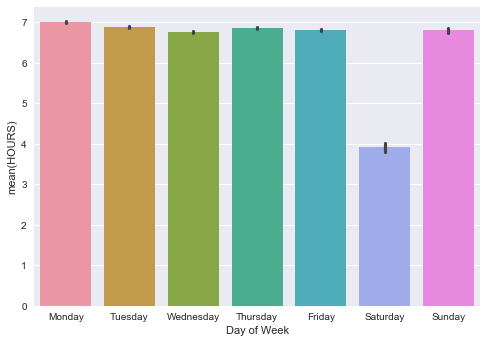

In [131]:
# Mean number of hours worked by day of week for not-injured workers

ax = sns.barplot(x='Day of Week', y="HOURS", data=not_injured_df, order= weekdays)

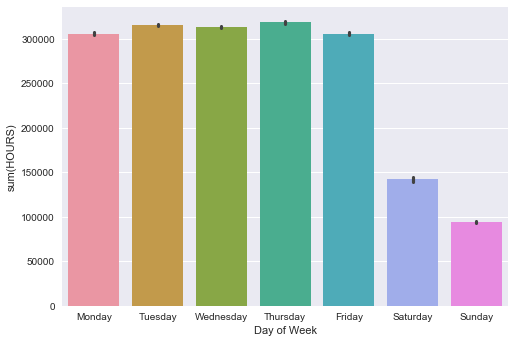

In [132]:
# Total number of hours worked by day of week for injured workers

ax = sns.barplot(x='Day of Week', y="HOURS", data=injured_df, 
                 order= weekdays, estimator = sum)

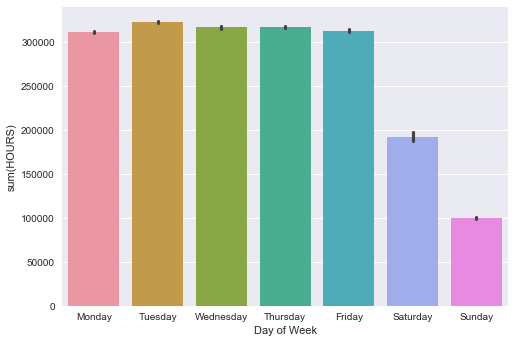

In [133]:
# Total number of hours worked by day of week for not-injured workers

ax = sns.barplot(x='Day of Week', y="HOURS", data=not_injured_df, 
                 order= weekdays, estimator = sum)

In [134]:
# Descriptions for variation codes with the word "holiday" in the description

vars_list = joined_df['VARIATION_DESCRIPTION'].unique().tolist()

def find_in_list(a_list, a_string):
    return [x for x in a_list if a_string.lower() in str(x).strip().lower()]

descrip_list = find_in_list(vars_list, 'HOLIDAY')
descrip_list

['HOLIDAY HOURS (CREDIT OR CHARGE)',
 'FLOATING HOLIDAY HOURS TAKEN THIS PAY PERIOD',
 'Floating Holiday Lost',
 'FML USING HOLIDAY',
 'FML USING FLOATING HOLIDAY',
 'ABSENT WITHOUT PAY - FLOATING HOLIDAY',
 'FLOATING HOLIDAY ACCRUED HOURS BALANCE  (REPLACE)',
 'PAID OVERTIME (HOLIDAY 1.5)']

In [135]:
# Variation codes associated with the above description list
# Need to look into these to find out how they're commonly used in the dataset, which would be most relevant

holiday_list= joined_df[joined_df['VARIATION_DESCRIPTION'].isin(descrip_list)]['VAR_CODE'].unique().tolist()

holiday_list

['HO', 'FH', 'O2', 'F5', 'FD', '8H', 'AM', 'PH']

In [136]:
# Variation codes counted by number of individual individual employees that have used it

joined_df.groupby(['VARIATION_DESCRIPTION', 'VAR_CODE'])['EMPLOYEE_NAME'].nunique().sort_values(ascending = False)

VARIATION_DESCRIPTION                                               VAR_CODE
UNIFORM ALLOWANCE                                                   UA          748
CURRENT ACTUAL HOURS WORKED ONLY                                    HW          736
HOLIDAY HOURS (CREDIT OR CHARGE)                                    HO          620
VACATION (POS AND NEG)                                              VC          577
FLOATING HOLIDAY HOURS TAKEN THIS PAY PERIOD                        FH          577
OVERTIME (1.5) WORKED AND PAID                                      PA          565
100% SICK TIME (CREDIT OR CHARGE)                                   SK          564
FAMILY ILLNESS (POS OR NEG)                                         FI          506
PREVENTIVE MEDICINE (POS OR NEG)                                    PM          313
OVERTIME TAKEN OFF  (1.5)                                           TO          307
TRAVEL ALLOWANCE                                                    TX          286

In [137]:
# Variation codes used by not-injured workers, counted by total and mean hours, sorted by mean hours

joined_df[joined_df['EMPLOYEE_NAME'].isin(not_injured_list)].groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['HOURS']\
    .agg({'total':sum,   
          'mean': 'mean'}).sort_values(by = 'mean', ascending = False)


,,mean,total
VAR_CODE,VARIATION_DESCRIPTION,,
87,50% SICK TIME BALANCE PAID AT RETIREMENT,449.764706,7646
86,100% SICK TIME BALANCE PAID AT RETIREMENT,400.500000,2403
83,VACATION BALANCE PAID AT TERMINATION/RETIREMENT,144.823529,4924
A7,SICK 100% CURRENT,72.000000,216
A1,SICK 100% ACCUMULATED,56.000000,112
80,PMT OF EXES SICKLEAVE OVER 800 HRS AT 100% PAID AT 50% (PG,55.020833,2641
88,BANKED EXCESS SICK TIME - PAID AT TERMINATION/RETIREMENT,43.000000,86
A8,SICK 75% CURRENT,40.000000,80
A2,SICK 75% ACCUMULATED,40.000000,40


In [138]:
# Variation codes used by injured workers, counted by total and mean hours, sorted by mean hours

joined_df[joined_df['EMPLOYEE_NAME'].isin(injured_list)].groupby(['VAR_CODE', 'VARIATION_DESCRIPTION'])['PAY_AMOUNT']\
        .agg({'total':sum,   
          'mean': 'mean'}).sort_values(by = 'mean', ascending = False)


,,mean,total
VAR_CODE,VARIATION_DESCRIPTION,,
87,50% SICK TIME BALANCE PAID AT RETIREMENT,2485.375000,19883
83,VACATION BALANCE PAID AT TERMINATION/RETIREMENT,2383.250000,28599
FO,SETTLEMENT,1600.000000,4800
80,PMT OF EXES SICKLEAVE OVER 800 HRS AT 100% PAID AT 50% (PG,755.518519,20399
OP,OVERTIME PAYMENT CONVERTED FROM OT (1.5),306.750000,1227
PA,OVERTIME (1.5) WORKED AND PAID,267.571843,9223469
FD,FML USING FLOATING HOLIDAY,258.000000,516
MP,MILITARY LEAVE WITH PAY (POS OR NEG),248.073298,47382
TU,TEMPORARY VARIATION IN RATE - UP,245.458023,461952


In [139]:
# Unique descriptions of how injury occured listed under the nature of injury "Mental Stress"

inj_mask = (joined_df['Nature of Injury']=='Mental Stress')
joined_df[inj_mask]['How Incident Occurred'].unique()

array([ 'ROUTINE PATROL. CE APPROACHED CITIZEN  IN THE CAR WHEN LAPD CAME AROUND W/GUNS DRAWN & ORDERED CITIZEN TO SHOW HANDS & ORDERS GIVEN.',
       "constant request to find ee's working restriction and verbal warning lead to stress, anxiousness, irritableness, sleeplessness,  nervousness & feeling desperate",
       'MEETING WITH SUPERVISOR. STRESS & ANXIETY CAUSING BLOOD PRESSURE TO RISE/ELEVATE',
       'CE was shoved from behind by a citizen while writing a citation. CE was then threatend with arrest by LAPD after being assaulted ',
       'CE was sitting at a table in the roll call room when the supv began to confront Ce regaing her FMLA "Delayed and decision due 4/13/15"',
       ' CE STATED WHILE ON PATROL, A CITIZEN POINTED A GUN  ON HIM AND THREATNED TO SHOOT/KILL HIM',
       'STRESS. DUE TO WORK ISSUES FROM SUPERVISOR.  DAILY HEADACHE, ANXIETY, LOSS OF SLEEP  AND NAUSEA. ONGOING SINCE MARCH 16, 2016',
       ' CE STATED THAT HIS VEHICLE WAS SURROUNDED BY A GROUP OF CITIZE